In [311]:
import pandas as pd
import seaborn as sns
from matplotlib.pyplot import figure
# Regression model
import statsmodels.api as sm
from patsy import dmatrices
from sklearn import metrics

olympics = pd.read_csv('athlete_events.csv')
olympics.shape
olympics.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [82]:
#list(df)
#set (df['City'])
print(olympics.isnull().sum())


ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


In [83]:
#df1=df.set_index('City')
#df
#France_df=df1.loc[['Paris','Chamonix','Grenoble']]
#France_df
'''
We find that height, weight and Age have a lot of missing values. 
Medals have a NaN in about 2,31,333 rows. These can be explained 
since not all participating athletes would win medals. 
Let's replace these missing values by 'Lost'
'''
olympics['Medal'].fillna('Lost', inplace = True)
print(olympics.isnull().sum())

ID            0
Name          0
Sex           0
Age        9474
Height    60171
Weight    62875
Team          0
NOC           0
Games         0
Year          0
Season        0
City          0
Sport         0
Event         0
Medal         0
dtype: int64


In [84]:
#Female_world=df[(df[df.Sex=='F'].Weight.dropna()),(df[df.Sex=='M'].Weight.dropna())]
#Female_France=df((France_df[France_df.Sex=='F'].Weight.dropna()),(France_df[France_df.Sex=='M'].Weight.dropna()))

#sns.distplot(Female_world)
'''
2) NOC - National Olympic Committee.
These are responsible for organizing their people's participation 
in the Olympics. Are all NOCs linked to a unique team? We can find 
this out by taking a unique subset of just the NOC and team columns 
and taking a value count.
'''
print(olympics.loc[:, ['NOC', 'Team']].drop_duplicates()['NOC'].value_counts())


FRA    160
USA     97
GBR     96
SWE     52
NOR     46
      ... 
CRO      1
PLW      1
PAK      1
GEQ      1
NBO      1
Name: NOC, Length: 230, dtype: int64


In [85]:
'''
Hmm, This looks interesting. So NOC code 'FRA' is associated with 160 teams? 
That sounds prepostorous! Let's use a master of NOC to country mapping to 
correct this.
The NOC data has the NOC code and the corresponding Country Name. 
The first five rows of the data are shown below -
'''
# Lets read in the noc_country mapping first
noc_country = pd.read_csv('noc_regions.csv')
noc_country.drop('notes', axis = 1 , inplace = True)
noc_country.rename(columns = {'region':'Country'}, inplace = True)

noc_country

,NOC,Country
0,AFG,Afghanistan
1,AHO,Curacao
2,ALB,Albania
3,ALG,Algeria
4,AND,Andorra
...,...,...
225,YEM,Yemen
226,YMD,Yemen
227,YUG,Serbia
228,ZAM,Zambia


In [86]:
'''
We now need to merge the original dataset with the NOC master using 
the NOC code as the primary key. This has to be a left join since 
we want all participating countries to remain in the data even if 
their NOC-Country is not found in the master. We can easily correct 
those manually.
'''
# merging
olympics_merge = olympics.merge(noc_country,
                                left_on = 'NOC',
                                right_on = 'NOC',
                                how = 'left')

In [87]:
'''
Even after merging, we find that the below NOC codes in the Olympics 
data had no counterpart in the NOC master data.
'''
# Do we have NOCs that didnt have a matching country in the master?
olympics_merge.loc[olympics_merge['Country'].isnull(),['NOC', 'Team']].drop_duplicates()


,NOC,Team
578,SGP,Singapore
6267,ROT,Refugee Olympic Athletes
44376,SGP,June Climene
61080,UNK,Unknown
64674,TUV,Tuvalu
80986,SGP,Rika II
108582,SGP,Singapore-2
235895,SGP,Singapore-1


In [107]:
'''
Looking at their 'Team' names we can manually insert the correct 
values into the olympics data.
Let's put these values in Country
1. SGP - Singapore
2. ROT - Refugee Olympic Athletes
3. UNK - Unknown
4. TUV - Tuvalu
'''
# Replace missing Teams by the values above.
#olympics_merge.loc[olympics_merge['Country'].isnull(), ['Country']] = olympics_merge['Team']

olympics_merge['Country'] = np.where(olympics_merge['NOC']=='SGP', 'Singapore', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='ROT', 'Refugee Olympic Athletes', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='UNK', 'Unknown', olympics_merge['Country'])
olympics_merge['Country'] = np.where(olympics_merge['NOC']=='TUV', 'Tuvalu', olympics_merge['Country'])


# Put these values from Country into Team
df_olympics= olympics_merge.drop('Team', axis = 1)
df_olympics.rename(columns = {'Country': 'Team'}, inplace = True)
#print(olympics_merge)
df_olympics

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Lost,China
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,Lost,China
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,Lost,Denmark
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,Lost,Netherlands
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,Lost,Poland
271112,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Lost,Poland
271113,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Lost,Poland
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,Lost,Poland


In [102]:
"""
Merge GDP data
To effectively study factors that affect the medal tally of a country, 
we need to import the Country-Year wise GDP data. THe GDP data has Country 
name, code, year and the GDP value. Some unnecessary columns Indicator Name 
and Indicator Code were removed. GDP data is shown below
"""
# Glance at the data.
w_gdp = pd.read_excel('world_gdp.xls', skiprows = 3)

# Remove unnecessary columns
w_gdp.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

# The columns are the years for which the GDP has been recorded. This needs to brought into a single column for efficient
# merging.
w_gdp = pd.melt(w_gdp, id_vars = ['Country Name', 'Country Code'], var_name = 'Year', value_name = 'GDP')

# convert the year column to numeric
w_gdp['Year'] = pd.to_numeric(w_gdp['Year'])

w_gdp

,Country Name,Country Code,Year,GDP
0,Afghanistan,AFG,1960,5.377778e+08
1,Albania,ALB,1960,NaN
2,Algeria,DZA,1960,2.723649e+09
3,American Samoa,ASM,1960,NaN
4,Andorra,AND,1960,NaN
...,...,...,...,...
12697,Virgin Islands (U.S.),VIR,2017,NaN
12698,West Bank and Gaza,PSE,2017,NaN
12699,"Yemen, Rep.",YEM,2017,NaN
12700,Zambia,ZMB,2017,NaN


In [103]:
'''
Before we actually merge, lets check if NOCs in the olympics 
data match with those in the Country Code.
'''
len(list(set(df_olympics['NOC'].unique()) - set(w_gdp['Country Code'].unique())))

108

In [104]:
'''
So, 108 NOCs in the olympics dataset dont have representation in the 
gdp data country codes. Is the name of the country a better way to merge?
'''
len(list(set(df_olympics['Team'].unique()) - set(w_gdp['Country Name'].unique())))

36

In [124]:
'''
Aha! only 36! So maybe what we can do is, add a country code for each 
Team in the olympics dataset first and then merge using the Country Code. 
The data now has GDP data attached
'''
# Merge to get country code
olympics_merge_ccode = df_olympics.merge(w_gdp[['Country Name', 'Country Code']].drop_duplicates(),
                                            left_on = 'Team',
                                            right_on = 'Country Name',
                                            how = 'left')

olympics_merge_ccode.drop('Country Name', axis = 1, inplace = True)

# Merge to get gdp too
olympics_merge_gdp = olympics_merge_ccode.merge(w_gdp,
                                                left_on = ['Country Code', 'Year'],
                                                right_on = ['Country Code', 'Year'],
                                                how = 'left')

olympics_merge_gdp.drop('Country Name', axis = 1, inplace = True)
olympics_merge_gdp

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Lost,China,CHN,4.269157e+11
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,Lost,China,CHN,8.560547e+12
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,Lost,Denmark,DNK,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,Lost,Netherlands,NLD,2.585678e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,Lost,Poland,POL,NaN
271112,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Lost,Poland,POL,5.450759e+11
271113,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Lost,Poland,POL,5.450759e+11
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,Lost,Poland,POL,1.743883e+11


In [129]:
'''
Merge Population Data
Apart from GDP, population is also of import when looking at a countries performance. 
There are two trains of thought for this -

Higher populations mean a bigger talent pool to choose from,
Its not GDP alone but GDP per capita that decides how much resources a country has.
The first five rows of the population data are shown below. This dataset has Country, 
year and population statistic. Again, Indicator Code and Indicator Name were deemed 
unnecessary and removed.
'''
# Read in the population data
w_pop = pd.read_csv('world_pop.csv')

w_pop.drop(['Indicator Name', 'Indicator Code'], axis = 1, inplace = True)

w_pop = pd.melt(w_pop, id_vars = ['Country', 'Country Code'], var_name = 'Year', value_name = 'Population')

# Change the Year to integer type

w_pop['Year'] = pd.to_numeric(w_pop['Year'],errors='coerce')

w_pop

,Country,Country Code,Year,Population
0,Aruba,ABW,1960.0,54211.0
1,Afghanistan,AFG,1960.0,8996351.0
2,Angola,AGO,1960.0,5643182.0
3,Albania,ALB,1960.0,1608800.0
4,Andorra,AND,1960.0,13411.0
...,...,...,...,...
12581,Kosovo,XKX,NaN,NaN
12582,"Yemen, Rep.",YEM,NaN,NaN
12583,South Africa,ZAF,NaN,NaN
12584,Zambia,ZMB,NaN,NaN


In [130]:
'''
Merging this data on Year and Country Code we finally get a complete dataset with GDP 
and Population mapped. A few sample rows are shown below.
'''
olympics_complete = olympics_merge_gdp.merge(w_pop,
                                            left_on = ['Country Code', 'Year'],
                                            right_on= ['Country Code', 'Year'],
                                            how = 'left')

olympics_complete.drop('Country', axis = 1, inplace = True)

olympics_complete

,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population
0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Lost,China,CHN,4.269157e+11,1.164970e+09
1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,Lost,China,CHN,8.560547e+12,1.350695e+09
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,Lost,Denmark,DNK,NaN,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold,Denmark,DNK,NaN,NaN
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,Lost,Netherlands,NLD,2.585678e+11,1.476009e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
271111,135569,Andrzej ya,M,29.0,179.0,89.0,POL,1976 Winter,1976,Winter,Innsbruck,Luge,Luge Mixed (Men)'s Doubles,Lost,Poland,POL,NaN,3.435630e+07
271112,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Individual",Lost,Poland,POL,5.450759e+11,3.801174e+07
271113,135570,Piotr ya,M,27.0,176.0,59.0,POL,2014 Winter,2014,Winter,Sochi,Ski Jumping,"Ski Jumping Men's Large Hill, Team",Lost,Poland,POL,5.450759e+11,3.801174e+07
271114,135571,Tomasz Ireneusz ya,M,30.0,185.0,96.0,POL,1998 Winter,1998,Winter,Nagano,Bobsleigh,Bobsleigh Men's Four,Lost,Poland,POL,1.743883e+11,3.866348e+07


In [131]:
'''
There are a lot of missing values in the resulting data - 
this is to be attributed to the countries not found in the GDP and population
masters and also the fact that Population and GDP are only for 1961 onwards while 
Olympics data is from 1896. Therefore, let's consider only data from 1961 onwards.
'''
olympics_complete.isnull().sum()

ID                   0
Name                 0
Sex                  0
Age               9474
Height           60171
Weight           62875
NOC                  0
Games                0
Year                 0
Season               0
City                 0
Sport                0
Event                0
Medal                0
Team                 0
Country Code     56427
GDP             122678
Population      106827
dtype: int64

In [134]:
# Lets take data from 1961 onwards only and for summer olympics only
olympics_complete_subset = olympics_complete.loc[(olympics_complete['Year'] > 1960) & (olympics_complete['Season'] == "Summer"), :]

# Reset row indices
olympics_complete_subset = olympics_complete_subset.reset_index()
olympics_complete_subset.isnull().sum()

index               0
ID                  0
Name                0
Sex                 0
Age               827
Height           7030
Weight           7294
NOC                 0
Games               0
Year                0
Season              0
City                0
Sport               0
Event               0
Medal               0
Team                0
Country Code    32742
GDP             45128
Population      33902
dtype: int64

In [137]:
'''
Exploratory Data Analysis
Who has the most medals across all editions of the olympics?
Medal tally is the sum of all medals won.
Let's create a column that captures whether or not a medal was won! 
It would be 1 if Medal column says Gold, Silver or Bronze and 0 otherwise.
'''
olympics_complete_subset['Medal_Won'] = np.where(olympics_complete_subset.loc[:,'Medal'] == 'Lost', 0, 1)
olympics_complete_subset

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,Season,City,Sport,Event,Medal,Team,Country Code,GDP,Population,Medal_Won
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,Lost,China,CHN,4.269157e+11,1.164970e+09,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,Lost,China,CHN,8.560547e+12,1.350695e+09,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,Summer,Sydney,Badminton,Badminton Men's Singles,Lost,Finland,FIN,1.255399e+11,5.176209e+06,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,Summer,Atlanta,Sailing,Sailing Women's Windsurfer,Lost,Finland,FIN,1.320994e+11,5.124573e+06,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,Summer,Sydney,Sailing,Sailing Women's Windsurfer,Lost,Finland,FIN,1.255399e+11,5.176209e+06,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158143,271106,135565,Fernando scar Zylberberg,M,27.0,168.0,76.0,ARG,2004 Summer,2004,Summer,Athina,Hockey,Hockey Men's Hockey,Lost,Argentina,ARG,1.646579e+11,3.872870e+07,0
158144,271107,135566,"James Francis ""Jim"" Zylker",M,21.0,175.0,75.0,USA,1972 Summer,1972,Summer,Munich,Football,Football Men's Football,Lost,USA,NaN,NaN,NaN,0
158145,271108,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.0,RUS,2000 Summer,2000,Summer,Sydney,Rowing,Rowing Men's Lightweight Coxless Fours,Lost,Russia,NaN,NaN,NaN,0
158146,271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.0,RUS,2004 Summer,2004,Summer,Athina,Rowing,Rowing Men's Lightweight Coxless Fours,Lost,Russia,NaN,NaN,NaN,0


In [147]:
'''
Before we find out the best olympics nations, we need to realise that each row of 
the data actually represents whether or not an athlete won a medal or not. 
This means that for team events, just a sum of the 'Medal_Won' column would give 
us an incorrect picture of the medal tally.

We need to correct for this. First, lets analyse which events are team events. 
So, what events are team events?

If a team wins more than one gold medal for an event in an edition of the olympics,
then that event is a team event.
'''
# Check whether number of medals won in a year for an event by a team exceeds 1. This indicates a team event.
identify_team_events = pd.pivot_table(olympics_complete_subset,
                                      index = ['Team', 'Year', 'Event'],
                                      columns = 'Medal',
                                      values = 'Medal_Won',
                                      aggfunc = 'sum',
                                     fill_value = 0).drop('Lost', axis = 1).reset_index()

identify_team_events = identify_team_events.loc[identify_team_events['Gold'] > 1, :]
identify_team_events

team_sports = identify_team_events['Event'].unique()
team_sports


array(["Basketball Men's Basketball", "Football Men's Football",
       "Cycling Men's Madison", "Hockey Men's Hockey",
       'Sailing Mixed Multihull', 'Sailing Mixed 5.5 metres',
       'Sailing Mixed Three Person Keelboat',
       'Sailing Mixed Two Person Keelboat',
       "Swimming Men's 4 x 100 metres Medley Relay",
       "Cycling Men's Team Pursuit, 4,000 metres",
       "Hockey Women's Hockey",
       'Equestrianism Mixed Three-Day Event, Team',
       "Rowing Men's Coxless Fours", "Rowing Men's Double Sculls",
       "Rowing Women's Coxless Pairs", "Tennis Men's Doubles",
       "Beach Volleyball Women's Beach Volleyball",
       "Sailing Men's Two Person Dinghy",
       "Sailing Women's Two Person Dinghy",
       "Swimming Men's 4 x 100 metres Freestyle Relay",
       "Swimming Men's 4 x 200 metres Freestyle Relay",
       "Water Polo Women's Water Polo", "Rowing Men's Coxless Pairs",
       "Swimming Women's 4 x 100 metres Freestyle Relay",
       "Swimming Women's 4 x 100

In [149]:
'''
The next thing we need to do is add a column in the dataset that 
correctly identifies whether the event in the given record is a 
team event or a single event. We then use this column to correctly 
calculate the medal tally for each country.

'''
# if an event name matches with one in team sports, then it is a team event. Others are singles events.
team_event_mask = olympics_complete_subset['Event'].map(lambda x: x in team_sports)
single_event_mask = [not i for i in team_event_mask]

# rows where medal_won is 1
medal_mask = olympics_complete_subset['Medal_Won'] == 1

# Put 1 under team event if medal is won and event in team event list
olympics_complete_subset['Team_Event'] = np.where(team_event_mask & medal_mask, 1, 0)

# Put 1 under singles event if medal is won and event not in team event list
olympics_complete_subset['Single_Event'] = np.where(single_event_mask & medal_mask, 1, 0)

# Add an identifier for team/single event
olympics_complete_subset['Event_Category'] = olympics_complete_subset['Single_Event'] + \
olympics_complete_subset['Team_Event']
olympics_complete_subset

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
0,0,1,A Dijiang,M,24.0,180.0,80.0,CHN,1992 Summer,1992,...,Basketball Men's Basketball,Lost,China,CHN,4.269157e+11,1.164970e+09,0,0,0,0
1,1,2,A Lamusi,M,23.0,170.0,60.0,CHN,2012 Summer,2012,...,Judo Men's Extra-Lightweight,Lost,China,CHN,8.560547e+12,1.350695e+09,0,0,0,0
2,31,12,Jyri Tapani Aalto,M,31.0,172.0,70.0,FIN,2000 Summer,2000,...,Badminton Men's Singles,Lost,Finland,FIN,1.255399e+11,5.176209e+06,0,0,0,0
3,32,13,Minna Maarit Aalto,F,30.0,159.0,55.5,FIN,1996 Summer,1996,...,Sailing Women's Windsurfer,Lost,Finland,FIN,1.320994e+11,5.124573e+06,0,0,0,0
4,33,13,Minna Maarit Aalto,F,34.0,159.0,55.5,FIN,2000 Summer,2000,...,Sailing Women's Windsurfer,Lost,Finland,FIN,1.255399e+11,5.176209e+06,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158143,271106,135565,Fernando scar Zylberberg,M,27.0,168.0,76.0,ARG,2004 Summer,2004,...,Hockey Men's Hockey,Lost,Argentina,ARG,1.646579e+11,3.872870e+07,0,0,0,0
158144,271107,135566,"James Francis ""Jim"" Zylker",M,21.0,175.0,75.0,USA,1972 Summer,1972,...,Football Men's Football,Lost,USA,NaN,NaN,NaN,0,0,0,0
158145,271108,135567,Aleksandr Viktorovich Zyuzin,M,24.0,183.0,72.0,RUS,2000 Summer,2000,...,Rowing Men's Lightweight Coxless Fours,Lost,Russia,NaN,NaN,NaN,0,0,0,0
158146,271109,135567,Aleksandr Viktorovich Zyuzin,M,28.0,183.0,72.0,RUS,2004 Summer,2004,...,Rowing Men's Lightweight Coxless Fours,Lost,Russia,NaN,NaN,NaN,0,0,0,0


In [153]:
'''
Now, its time to calculate medal tally agnostic of the team size - 
one gold means one gold for an event. To do this we divide the number 
of medals by the count of winning team members. How do we get the team members?
Sum of event_category column should do that for us!
'''

medal_tally_agnostic = olympics_complete_subset.\
groupby(['Year', 'Team', 'Event', 'Medal'])[['Medal_Won', 'Event_Category']].\
agg('sum').reset_index()

medal_tally_agnostic['Medal_Won_Corrected'] = medal_tally_agnostic['Medal_Won']/medal_tally_agnostic['Event_Category']
medal_tally_agnostic

,Year,Team,Event,Medal,Medal_Won,Event_Category,Medal_Won_Corrected
0,1964,Afghanistan,"Wrestling Men's Bantamweight, Freestyle",Lost,0,0,NaN
1,1964,Afghanistan,"Wrestling Men's Bantamweight, Greco-Roman",Lost,0,0,NaN
2,1964,Afghanistan,"Wrestling Men's Featherweight, Freestyle",Lost,0,0,NaN
3,1964,Afghanistan,"Wrestling Men's Featherweight, Greco-Roman",Lost,0,0,NaN
4,1964,Afghanistan,"Wrestling Men's Flyweight, Freestyle",Lost,0,0,NaN
...,...,...,...,...,...,...,...
80343,2016,Zimbabwe,Rowing Women's Single Sculls,Lost,0,0,NaN
80344,2016,Zimbabwe,Shooting Men's Double Trap,Lost,0,0,NaN
80345,2016,Zimbabwe,Swimming Men's 100 metres Freestyle,Lost,0,0,NaN
80346,2016,Zimbabwe,Swimming Women's 100 metres Backstroke,Lost,0,0,NaN


In [188]:
'''
Who are the greatest olympics playing nations of all time? 
With the corrected data, lets find out the total medal tally 
of the top 4 countries from 1964 to 2016!
'''
# Medal Tally.
medal_tally = medal_tally_agnostic.groupby(['Year','Team'])['Medal_Won_Corrected'].agg('sum').reset_index()

medal_tally_pivot = pd.pivot_table(medal_tally,
                     index = 'Team',
                     columns = 'Year',
                     values = 'Medal_Won_Corrected',
                     aggfunc = 'sum',
                     margins = True).sort_values('All', ascending = False)[1:15]

# print total medals won in the given period
medal_tally_pivot.loc[:,'All']


Team
USA            1387.0
Russia         1298.0
Germany        1042.0
China           545.0
UK              417.0
Australia       390.0
France          365.0
Japan           348.0
Italy           338.0
Hungary         294.0
Romania         274.0
South Korea     257.0
Poland          227.0
Cuba            207.0
Name: All, dtype: float64

Text(0.5, 1.0, 'Olympic Performance of France')

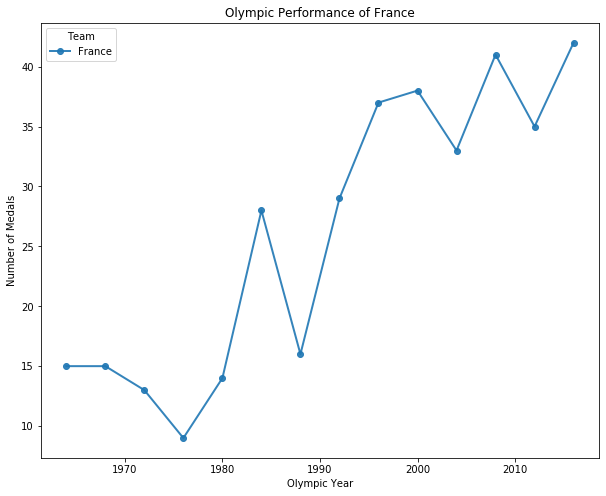

In [315]:
'''
USA, Russia, Germany and China are the best countries of all time when 
it comes to medal tallies from 1964 to 2016. But I am interrested in France position
in the Olympics. so what do the yearwise medal tallies look like for FRA?
'''
# List of some EU countries including France
Lyon_country = ['France']

year_team_medals = pd.pivot_table(medal_tally,
                                  index = 'Year',
                                  columns = 'Team',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum')[Lyon_country]

# plotting the medal tallies
year_team_medals.plot(linestyle = '-', marker = 'o', alpha = 0.9, figsize = (10,8), linewidth = 2)
xlabel('Olympic Year')
ylabel('Number of Medals')
title('Olympic Performance of France')

Text(0, 0.5, 'Country')

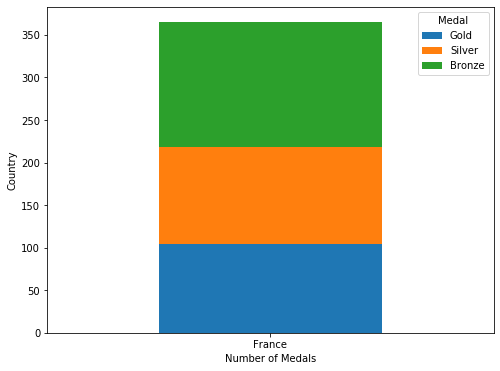

In [235]:

# row mask where countries match
row_mask_2 = medal_tally_agnostic['Team'].map(lambda x: x in Lyon_country)

# Pivot table to calculate sum of gold, silver and bronze medals for France
medal_tally_specific = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                     index = ['Team'],
                                     columns = 'Medal',
                                     values = 'Medal_Won_Corrected',
                                     aggfunc = 'sum',
                                     fill_value = 0).drop('Lost', axis = 1)

# Re-order the columns so that they appear in order on the chart.
medal_tally_specific = medal_tally_specific.loc[:, ['Gold', 'Silver', 'Bronze']]

medal_tally_specific.plot(kind = 'bar', stacked = True, figsize = (8,6), rot = 0)
xlabel('Number of Medals')
ylabel('Country')

In [236]:
# To get the sports, teams are best at, we now aggregate the medal_tally_agnostic dataframe as we did earlier.
best_team_sports = pd.pivot_table(medal_tally_agnostic[row_mask_2],
                                  index = ['Team', 'Event'],
                                  columns = 'Medal',
                                  values = 'Medal_Won_Corrected',
                                  aggfunc = 'sum',
                                  fill_value = 0).sort_values(['Team', 'Gold'], ascending = [True, False]).reset_index()

best_team_sports.drop(['Bronze', 'Silver', 'Lost'], axis = 1, inplace = True)
best_team_sports.columns = ['Team', 'Event', 'Gold_Medal_Count']

best_team_sports.groupby('Team').head(2)

,Team,Event,Gold_Medal_Count
0,France,"Fencing Men's epee, Team",5
1,France,Judo Men's Heavyweight,5


In [325]:
'''
Size of Olympic contingent that France send to the Olympics!
How do the contingents for France look like? I want to 
know two things specifically 
1-
The total contingent size being sent to the Olympics
2-
The team constitution in terms of the proportion of males and females.
'''

# take for each year, the team, name of the athlete and gender of the athlete and drop duplicates. These are values
# where the same athlete is taking part in more than one sport.

# get rows 
row_mask_3 = olympics_complete_subset['Team'].map(lambda x: x in Lyon_country)

year_team_gender = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name', 'Sex']].drop_duplicates()
france_olympics=olympics_complete_subset[olympics_complete_subset.Team.isin(Lyon_country)]
france_olympics

,index,ID,Name,Sex,Age,Height,Weight,NOC,Games,Year,...,Event,Medal,Team,Country Code,GDP,Population,Medal_Won,Team_Event,Single_Event,Event_Category
18,98,34,Jamale (Djamel-) Aarrass (Ahrass-),M,30.0,187.0,76.0,FRA,2012 Summer,2012,...,"Athletics Men's 1,500 metres",Lost,France,FRA,2.681416e+12,65659790.0,0,0,0,0
37,145,52,Patrick Abada,M,22.0,189.0,80.0,FRA,1976 Summer,1976,...,Athletics Men's Pole Vault,Lost,France,FRA,3.734103e+11,54541493.0,0,0,0,0
56,173,73,Luc Abalo,M,23.0,182.0,86.0,FRA,2008 Summer,2008,...,Handball Men's Handball,Gold,France,FRA,2.923466e+12,64374990.0,1,1,0,1
57,174,73,Luc Abalo,M,27.0,182.0,86.0,FRA,2012 Summer,2012,...,Handball Men's Handball,Gold,France,FRA,2.681416e+12,65659790.0,1,1,0,1
58,175,73,Luc Abalo,M,31.0,182.0,86.0,FRA,2016 Summer,2016,...,Handball Men's Handball,Silver,France,FRA,2.465454e+12,66896109.0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157655,270229,135188,Andr Georges Zoete,M,33.0,156.0,52.0,FRA,1964 Summer,1964,...,"Wrestling Men's Flyweight, Freestyle",Lost,France,FRA,9.490659e+10,49449403.0,0,0,0,0
157789,270450,135278,Vincent Zouaoui-Dandrieux,M,27.0,188.0,72.0,FRA,2008 Summer,2008,...,"Athletics Men's 3,000 metres Steeplechase",Lost,France,FRA,2.923466e+12,64374990.0,0,0,0,0
157790,270451,135278,Vincent Zouaoui-Dandrieux,M,31.0,188.0,72.0,FRA,2012 Summer,2012,...,"Athletics Men's 3,000 metres Steeplechase",Lost,France,FRA,2.681416e+12,65659790.0,0,0,0,0
157917,270662,135362,Michel Zucarelli,M,18.0,175.0,67.0,FRA,1972 Summer,1972,...,"Cycling Men's Individual Pursuit, 4,000 metres",Lost,France,FRA,2.042835e+11,52959228.0,0,0,0,0


In [238]:
# Create a pivot table to count gender wise representation of each team in each year
year_team_gender_count = pd.pivot_table(year_team_gender,
                                        index = ['Year', 'Team'],
                                        columns = 'Sex',
                                        aggfunc = 'count').reset_index()

# rename columns as per column names in the 0th level
year_team_gender_count.columns = year_team_gender_count.columns.get_level_values(0)

# rename the columns appropriately
year_team_gender_count.columns = ['Year', 'Team', 'Female_Athletes', 'Male_Athletes']

# get total athletes per team-year
year_team_gender_count['Total_Athletes'] = year_team_gender_count['Female_Athletes'] + \
year_team_gender_count['Male_Athletes']

In [316]:
# French wise data


fra_data = year_team_gender_count[year_team_gender_count['Team'] == "France"]
fra_data.set_index('Year', inplace = True)

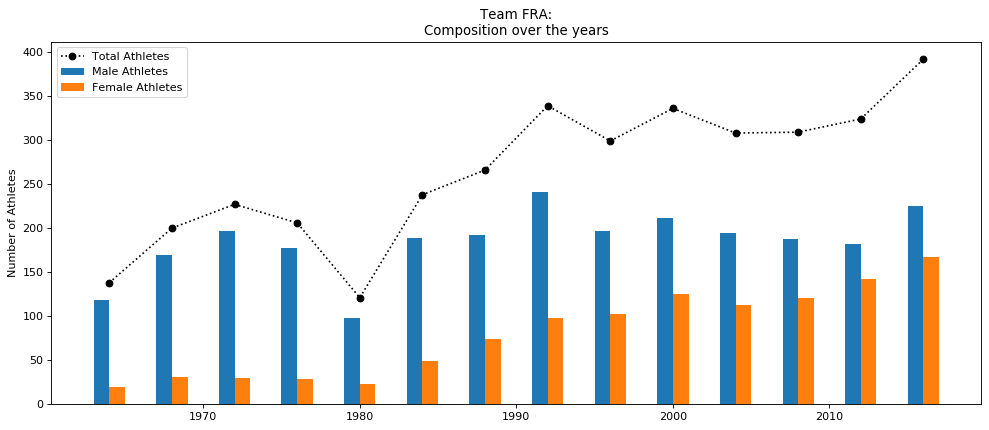

In [317]:
# Plot the values of male, female and total athletes using bar charts and the line charts.

# Plot team France's contingent size


figure(num=None, figsize=(15,6), dpi=80, facecolor='w', edgecolor='k')

bar(fra_data.index.values, fra_data['Male_Athletes'], width = -1, align = 'edge', label = 'Male Athletes')
bar(fra_data.index.values, fra_data['Female_Athletes'], width = 1, align = 'edge',label = 'Female Athletes')
plot(fra_data.index.values, fra_data['Total_Athletes'], linestyle = ':', color = 'black', label = 'Total Athletes',
        marker = 'o')
title('Team FRA:\nComposition over the years')
ylabel('Number of Athletes')
legend()


show()

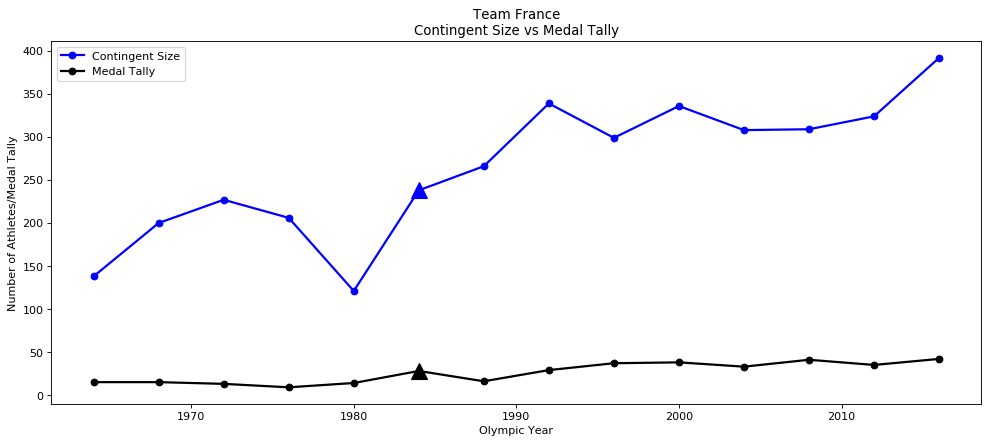

In [318]:
'''
Does the size of the contingent relate with the number of medals?
To get to this, I plot the number of medals won by a French team across 
the years with the French contingent size sent to the Olympics in those years.
'''

# Get year wise team wise athletes.
year_team_athelete = olympics_complete_subset.loc[row_mask_3, ['Year','Team', 'Name']].drop_duplicates()

# sum these up to get total contingent size.
contingent_size = pd.pivot_table(year_team_athelete,
                                 index = 'Year',
                                 columns = 'Team',
                                 values = 'Name',
                                 aggfunc = 'count')




# Plot FRANCE's medal tally and contingent size
figure(num=None, figsize=(15,6), dpi=80, facecolor='w', edgecolor='k')

contingent_size['France'].plot(linestyle = '-', marker = 'o', linewidth = 2, color = 'blue',
                           label = 'Contingent Size')
year_team_medals['France'].plot(linestyle = '-', marker = 'o', linewidth = 2, color = 'black',
                            label = 'Medal Tally')

plot(1984, contingent_size.loc[1984, 'France'], marker = '^', color = 'blue', ms = 14)
plot(1984, year_team_medals.loc[1984, 'France'], marker = '^', color = 'black', ms = 14)
xlabel('Olympic Year')
ylabel('Number of Athletes/Medal Tally')
title('Team France\nContingent Size vs Medal Tally')
legend(loc = 'best')

show()

In [290]:
# Lets merge contingent size and medals won!
year_team_medals_unstack = year_team_medals.unstack().reset_index()
year_team_medals_unstack.columns = ['Team','Year', 'Medal_Count']

contingent_size_unstack = contingent_size.unstack().reset_index()

contingent_size_unstack.columns = ['Team','Year', 'Contingent']

contingent_medals = contingent_size_unstack.merge(year_team_medals_unstack,
                                                 left_on = ['Team', 'Year'],
                                                 right_on = ['Team', 'Year'])

contingent_medals[['Contingent', 'Medal_Count']].corr()

,Contingent,Medal_Count
Contingent,1.000000,0.836678
Medal_Count,0.836678,1.000000


In [323]:
'''
The correlation matrix above confirms my conclusions from the plots! 
A large positive correlation (0.84) exists between contingent size 
and medal tally.

'''

# merge best team sports with olympics data to get sport for each event.
team_commonalities = best_team_sports.merge(olympics_complete_subset.loc[:,['Sport', 'Event']].drop_duplicates(),
                                           left_on = 'Event',
                                           right_on = 'Event')

team_commonalities = team_commonalities.sort_values(['Team', 'Gold_Medal_Count'], ascending = [True, False])
team_commonalities = team_commonalities.groupby('Team').head(5).reset_index()

# make a pivot table of the commonalities.
pd.pivot_table(team_commonalities,
              index = 'Sport',
              columns = 'Team',
              values = 'Event',
              aggfunc = 'count',
              fill_value = 0,
              margins = True)

Team,France,All
Sport,,
Athletics,2,2
Canoeing,1,1
Fencing,1,1
Judo,1,1
All,5,5


'text(np.nanpercentile(medal_tally_gdp[\'GDP\'], 99.6),\n     max(medal_tally_gdp[\'Medal_Won_Corrected\']) - 50,\n     "Correlation = " + str(correlation))'

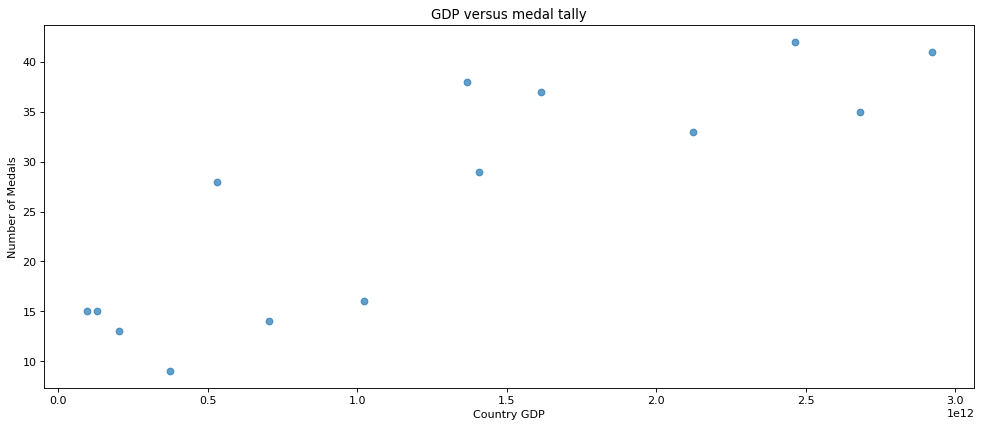

In [326]:
'''
Does GDP play a part in medal tallies?
GDP is a proxy for a country's resources. 
A higher GDP means more resources to allocate to sports!

'''


year_team_gdp =france_olympics.loc[:, ['Year', 'Team', 'GDP']].drop_duplicates()

medal_tally_gdp = medal_tally.merge(year_team_gdp,
                                   left_on = ['Year', 'Team'],
                                   right_on = ['Year', 'Team'],
                                   how = 'left')

row_mask_5 = medal_tally_gdp['Medal_Won_Corrected'] > 0
#row_mask_6 = medal_tally_gdp['Team'].map(lambda x: x in Lyon_country)

correlation = medal_tally_gdp.loc[row_mask_5, ['GDP', 'Medal_Won_Corrected']].corr()['Medal_Won_Corrected'][0]

figure(num=None, figsize=(15,6), dpi=80, facecolor='w', edgecolor='k')

plot(medal_tally_gdp.loc[row_mask_5, 'GDP'], 
     medal_tally_gdp.loc[row_mask_5, 'Medal_Won_Corrected'] , 
     linestyle = 'none', 
     marker = 'o',
     alpha = 0.7)
xlabel('Country GDP')
ylabel('Number of Medals')
title('GDP versus medal tally')
'''text(np.nanpercentile(medal_tally_gdp['GDP'], 99.6),
     max(medal_tally_gdp['Medal_Won_Corrected']) - 50,
     "Correlation = " + str(correlation))'''

In [327]:
print( np.nanpercentile(medal_tally_gdp['GDP'], 99.6),'\n',
      max(medal_tally_gdp['Medal_Won_Corrected']) - 50,'\n',
      "Correlation = " + str(correlation))

'''The plot shows a 0.858 correlation between GDP and medals won! 
Thats a significant correlation. So GDP positively impacts the number 
of medals won by a team.
'''

2910879074878.4546 
 145.0 
 Correlation = 0.8585735819004331


'The plot shows a 0.858 correlation between GDP and medals won! \nThats a significant correlation. So GDP positively impacts the number \nof medals won by a team.\n'

In [307]:
'''What are the most accomplished sports for France?
Lets define accomplished Sports as those with a high 
medal to participation ratio. This means the average number 
of medals they win with each participation. 
Participation would be counted as the number of events that 
they participated in.
'''
# lets create a data frame of athletes with the sport they participated in and the number of medals won.
ath_sport_medal = france_olympics.groupby(['Team', 'Sport'])['Medal_Won'].agg('sum').reset_index()
ath_sport_medal.set_index('Team',drop= True, inplace =True)
ath_sport_medal.sort_values(['Medal_Won','Sport'], ascending = [False, False], inplace = True)

# keep only athletes who won medals
medal_mask = ath_sport_medal['Medal_Won'] > 0
ath_sport_medal = ath_sport_medal[medal_mask]

ath_sport_medal

,Sport,Medal_Won
Team,,
France,Fencing,150
France,Handball,77
France,Cycling,63
France,Swimming,56
France,Athletics,52
France,Judo,49
France,Rowing,41
France,Canoeing,41
France,Equestrianism,37


In [308]:
'''

Can we predict the sport an athlete plays using just height and weight?

'''



# How many unique sports are there?
olympics_complete_subset['Sport'].unique()

array(['Basketball', 'Judo', 'Badminton', 'Sailing', 'Athletics',
       'Handball', 'Weightlifting', 'Wrestling', 'Water Polo', 'Hockey',
       'Rowing', 'Swimming', 'Football', 'Equestrianism', 'Boxing',
       'Gymnastics', 'Taekwondo', 'Fencing', 'Diving', 'Canoeing',
       'Tennis', 'Shooting', 'Cycling', 'Softball', 'Archery',
       'Volleyball', 'Synchronized Swimming', 'Modern Pentathlon',
       'Table Tennis', 'Baseball', 'Rhythmic Gymnastics', 'Rugby Sevens',
       'Trampolining', 'Beach Volleyball', 'Triathlon', 'Golf'],
      dtype=object)

In [309]:
# extract sports data for males and height, weight statistics

base_data_male =france_olympics.loc[france_olympics['Sex'] == "M",
                                              ['Sport', 'Age','Weight', 'Height']].drop_duplicates()

In [312]:
# Need to create y, X for the K nearest neighbors problem

Y, X = dmatrices('Sport ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

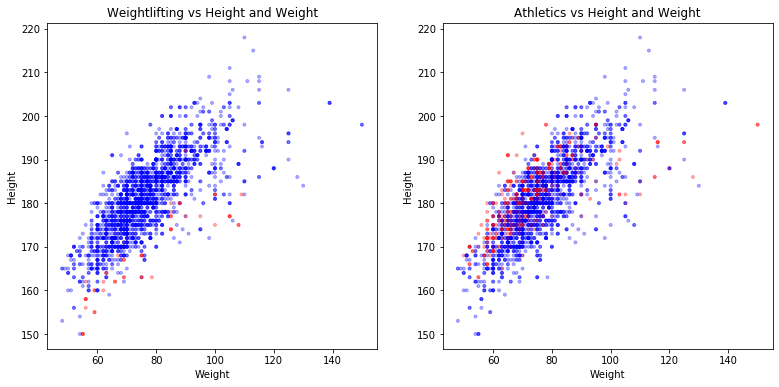

In [313]:
'''
Plotting for a few sports we see that, we can distinguish players who 
play athletics and weightlifting easily due to their unusual height or weight, 
but the rest of the sports look tricky to distinguish just on the basis of height and weight.
'''


fig, (ax1, ax2) = subplots(nrows = 1, ncols = 2, figsize = (13,6))

ax1.scatter(X['Weight'], X['Height'], c = Y['Sport[Weightlifting]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax1.set_title('Weightlifting vs Height and Weight')
ax1.set_xlabel('Weight')
ax1.set_ylabel('Height')

ax2.scatter(X['Weight'], X['Height'], c = Y['Sport[Athletics]'], cmap = 'bwr', marker = '.', alpha = 0.3)
ax2.set_title('Athletics vs Height and Weight')
ax2.set_xlabel('Weight')
ax2.set_ylabel('Height')

show()

In [314]:
'''Lets see how well we can predict Weightlifting given height and weight.
'''
base_data_male['target'] = np.where(base_data_male['Sport'] == 'Weightlifting', 1, 0)
# create the y and X matrices
from sklearn import model_selection
from sklearn import metrics
from sklearn import neighbors

Y, X = dmatrices('target ~ 0 + Weight + Height',
                data = base_data_male,
                return_type = 'dataframe')

y = Y['target'].values

accuracies = []

kfold = model_selection.StratifiedKFold(n_splits = 5, shuffle = True).split(X, y)

model = neighbors.KNeighborsClassifier(n_neighbors = 20,
                                      p = 2,
                                      weights = 'uniform')

for train, holdout in kfold:
    model.fit(X.iloc[train], y[train])
    prediction_on_test = model.predict(X.iloc[holdout])
    accuracies.append(metrics.accuracy_score(y[holdout], prediction_on_test))

np.mean(accuracies)

0.9791839679358716

In [ ]:
"""
The above accuracies show that given a height and weight I can predict the sport as 
being or not being weightlifting with 98% accuracy! This was because the weightlifters 
were so clearly visibile as separate on the weight/height scatterplot.
"""

'''

This was EXCITING!

We learnt that -


1- French women, who were not a very large part of the Olympics contingents earlier, 
now enjoy equal representation in the olympics teams.


2- We found interesting insights by looking at the most successful sporting events for France


3- GDP impacts the number of medals won by a nation positively!


4- It is also possible to predict some sports that an athlete plays using just his 
height and weight. We used a very simple K-Nearest neighbors model. This can obviously 
be improved upon!
'''